# Fig. 8 DAG perturbation
In this notebook we generate panels B, C, E, F, G and H of Figure 8. 

We compare centrosomal dynamics, engulfment rates, centrosome allignment and -motility for different types of DAG signalling perturbatio (PMA and PLCi).

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import statannot
from scipy.stats import mannwhitneyu
from astropy.stats import circvar

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ 
    Returns the angle in degree between vectors 'v1' and 'v2':
    >>> angle_between((1, 0, 0), (0, 1, 0))
    1.5707963267948966
    >>> angle_between((1, 0, 0), (1, 0, 0))
    0.0
    >>> angle_between((1, 0, 0), (-1, 0, 0))
    3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) / 2 / np.pi * 360

def angle_between_arrays(a1, a2):
    """Batch calculate the angle between two vectors."""
    angles = []
    for i in range(a1.shape[0]):
        v1 = a1[i,:]
        v2 = a2[i,:]
        angles.append(angle_between(v1, v2))
    return np.array(angles)

def listFiles(root):
    """Generate a list of all files under the root directory."""
    allFiles = []; walk = [root]
    while walk:
        folder = walk.pop(0)+"/"; items = os.listdir(folder) # items = folders + files
        for i in items: i=folder+i; (walk if os.path.isdir(i) else allFiles).append(i)
    return allFiles

def round_to_point_five(x):
    """Round a number to half integers."""
    return np.round(x * 2) / 2

In [3]:
def read_mtrackj(file):
    """
    Read in 2d tracking data from MTrackJ files and return a pd.DataFrame
    
    Return frame (time), track no, point no (of track), and xy coordinates (in pixels).
    """
    with open(file) as f:
        lines = f.readlines()
    out = []
    for l in lines:
        if l[:5] == 'Track':
            track = int(l.split(' ')[1])
        elif l[:5] == 'Point':
            sl = l.split(' ')
            pid = int(sl[1])
            x = float(sl[2])
            y = float(sl[3])
            t = float(sl[5])
            out.append([t, track, pid, x, y])
    df = pd.DataFrame(out, columns=('frame', 'track no', 'point no', 'x [px]', 'y [px]'))
    return df

In [4]:
def cart2pol(x, y):
    """Transform cartesian coordiantes to polar coordinates."""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    """Transform polar- to cartesian coordiantes."""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [5]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, color='b'):
    """
    Produce a circular histogram of angles on ax.
    
    From: 'jwalton': https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n / (0.001 + len(x)) *40

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='w', fill=True, linewidth=1, bottom=15, color=color)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

## Read in data and organise df
First, we have to read in the data from `MTrackJ` files located on the PeriGilmour Scr1 drive:
`Scratch-1/forMax_fromKatrin/Drug treatments/_condition_/_experimentID_fish-number_/_cell-number_/_files_`
Every cell has tracking files for `cell-body`, `centrosome`, `phagosome` (the latter in three flavours: branch mediated, non-branch mediated, failed).

We will read in the data raw and rearrange it such that we get a tidy dataframe with the columns t, loc_CS, loc_CB, loc_P, mode, condition, n_sample.

In [6]:
pixel_scale = 0.17 # um/pixel
pixel_scale_pma = 0.12 # um/pixel -- only for PMA experiments
time_scale = 0.5 #min/tp

In [7]:
files = listFiles('data/DAG_perturbation/')

In [8]:
f_l = []
for f in files:
    if 'nocodazole' in f.lower():
        continue
    else:
        f_l.append(f)
files = f_l

Make one tidy data frame from the tracking files.

In [9]:
df_list = []
for f in files:
    try:
        condition = f.split('/')[-4]
        name = os.path.split(f)[-1]
        eid = name.split('_')[0].lower()
        fn = name.split('_')[1].lower()
        cn = name.split('_')[2].lower()
        typ = name.split('_')[-1].split('.')[0].lower()
        sdf = read_mtrackj(f)
        sdf['experiment'] = eid
        sdf['fish'] = fn
        sdf['cell'] = cn
        if typ in ['bm-phagosomes', 'bm-phagosome', 'bm-engulfments']:
            sdf['type'] = 'phagosome branch'
        elif typ in ['nbm-phagosomes', 'nbm-phagosome']:
            sdf['type'] = 'phagosome non-branch'
        elif typ in ['failures', 'failurs']:
            sdf['type'] = 'phagosome failure'
        else:
            sdf['type'] = typ
        sdf['condition'] = condition
        if condition == 'PMA':
            sdf['x [µm]'] = sdf['x [px]'] * pixel_scale_pma
            sdf['y [µm]'] = sdf['y [px]'] * pixel_scale_pma
        else:
            sdf['x [µm]'] = sdf['x [px]'] * pixel_scale
            sdf['y [µm]'] = sdf['y [px]'] * pixel_scale

        sdf['time [min]'] = (sdf['frame'] - 1) * time_scale
        sdf['file'] = f
        sdf['cell id'] = '_'.join([eid, fn, cn])
        sdf['sample id'] = '_'.join([eid, fn])
        df_list.append(sdf)
    except:
        print(name)
        print(f)
raw = pd.concat(df_list)


.DS_Store
data/DAG_perturbation//.DS_Store
drug_treatment_analysis_summary.pdf
data/DAG_perturbation//plots/drug_treatment_analysis_summary.pdf
.DS_Store
data/DAG_perturbation//PLCi/.DS_Store
.DS_Store
data/DAG_perturbation//DMSOctrl/.DS_Store
.DS_Store
data/DAG_perturbation//PKCi/.DS_Store
.DS_Store
data/DAG_perturbation//PLCi/AK016_F2/.DS_Store
.DS_Store
data/DAG_perturbation//PKCi/AK024_F1/.DS_Store


Now, we expand this tidy dataframe into a wide representation, where the positions of centrosome, phagosome and cell body are temporally alligned for individual cells. This allows us to calculate the dynamics of the organelles and to define and classify phagocytic events.

In [10]:
df_list = []
for sid in raw['cell id'].unique():
    # cell body + auxilary info
    sdf = raw.loc[raw['cell id'] == sid].copy()
    ndf = sdf.loc[sdf['type'] == 'cell-body'].copy()
    ndf['phagocytic mode'] = None
    ndf.rename({'x [µm]': 'cell body x [µm]',
                'y [µm]': 'cell body y [µm]'},
               inplace=True,
               axis=1)
    ndf.drop(['type', 'file', 'x [px]', 'y [px]', 'track no', 'point no', 'frame'],
             inplace=True,
             axis=1)
    # centrosome
    adf = sdf.loc[sdf['type'] == 'centrosome', ['x [µm]', 'y [µm]', 'time [min]']].copy()
    ndf = ndf.merge(adf,
                  on=['time [min]'], how='inner').drop_duplicates()
    ndf.rename({'x [µm]': 'centrosome x [µm]',
                'y [µm]': 'centrosome y [µm]'},
                inplace=True,
                axis=1)
    # phagosome
    adf = sdf.loc[sdf['type'].str.contains('phagosome'), ['x [µm]', 'y [µm]', 'time [min]', 'type']].copy()
    adf['phagocytic mode'] = adf['type'].str.replace('phagosome ', '')
    adf.drop('type', inplace=True, axis=1)
    ndf = ndf.merge(adf,
                  on=['time [min]'], how='outer', suffixes=['_del', ''])
    ndf.rename({'x [µm]': 'phagosome x [µm]',
                'y [µm]': 'phagosome y [µm]'},
                inplace=True,
                axis=1)
    ndf.drop('phagocytic mode_del', inplace=True, axis=1)

    df_list.append(ndf)
df = pd.concat(df_list)
df.dropna(subset = ['experiment'], inplace=True)

Here we use `df_count` to remember the length of the tracks.

In [11]:
df_list = []
for cid in df['cell id'].unique():
    _sdf = df.loc[df['cell id'] == cid].copy()
    df_list.append([cid, _sdf['time [min]'].max() -  _sdf['time [min]'].min()])
df_count = pd.DataFrame(df_list, columns=['cell id', 'duration'])

Now we calculate the distance between the centrosome and the phagosome, and the corresponding speed.

In [12]:
centrosome = df[['centrosome x [µm]', 'centrosome y [µm]']].to_numpy().astype(float)
cell_body = df[['cell body x [µm]', 'cell body y [µm]']].to_numpy().astype(float)

df['distance cb-cs [µm]'] = (np.linalg.norm(cell_body - centrosome, axis= 1))

In [13]:
df_list = []
for cid in df['cell id'].unique():
    sdf = df.loc[df['cell id']==cid].copy()
    sdf['speed cs [µm/min]'] = np.absolute(np.gradient(sdf['distance cb-cs [µm]'].values))
    df_list.append(sdf)
df = pd.concat(df_list)

Now we generate 'phagocytic event windwos' that are the time points a cell is busy with a specific phagocytic event. Phagocytic event windows contain only one phagocytic event and are maximum -/+ 5min wide (10min total). If consecutive phagocytic events are closer than 10min, we trim their windows equidistantly, i.e. we change from one to the other in the temporal centre between them (for practical reasons, we overlap touching windows by one frame to avoid windows with width 0).

In [14]:
phago_window_width = 10 # min
event_list = []
for cid in df['cell id'].unique():
    sdf = df.loc[(df['cell id'] == cid)].copy()
    tp_p = sdf.loc[sdf['phagocytic mode'].notna(),['time [min]']].to_numpy().flatten()
    tp_p_pad = np.array([sdf['time [min]'].min()] + list(tp_p) + [sdf['time [min]'].max()])
    distance_between_events = tp_p_pad[1:] - tp_p_pad[:-1]
    event_cutoffs = round_to_point_five(np.clip(distance_between_events, 1, phago_window_width) / 2)
    for i, phago_event_tp in enumerate(tp_p):
        bound_low = phago_event_tp - event_cutoffs[i]
        bound_high = phago_event_tp + event_cutoffs[i+1]
        ssdf = sdf.loc[(sdf['time [min]'] >= bound_low) & (sdf['time [min]'] <= bound_high)].copy() 
        ssdf['event id'] = str(cid) + '_e{:03d}'.format(i)
        ssdf['phagocytic mode'] = ssdf['phagocytic mode'].dropna().values[0]
        ssdf['time event [min]'] = ssdf['time [min]'] - phago_event_tp
        event_list.append(ssdf)
events = pd.concat(event_list)
    


Next, we calculate the distances and angles between cell body/centrosome and phagosome

In [15]:
event_list = []
err_count = 0
for evid in events['event id'].unique():
    try:
        sdf = events.loc[events['event id'] == evid].copy()
        centrosome = sdf[['centrosome x [µm]', 'centrosome y [µm]']].to_numpy().astype(float)
        cell_body = sdf[['cell body x [µm]', 'cell body y [µm]']].to_numpy().astype(float)
        phagosome = sdf[['phagosome x [µm]', 'phagosome y [µm]']].dropna().to_numpy()[0,:].astype(float)

        sdf['distance cb-cs [µm]'] = (np.linalg.norm(cell_body - centrosome, axis= 1))
        sdf['distance cb-p [µm]'] = (np.linalg.norm(cell_body - phagosome, axis= 1))
        sdf['distance cs-p [µm]'] = (np.linalg.norm(centrosome - phagosome, axis= 1))

        sdf['angle cb-cs'] = angle_between_arrays(cell_body - phagosome, centrosome - phagosome)
        sdf['angle cb-p'] = angle_between_arrays(cell_body - centrosome, phagosome - centrosome)
        sdf['angle cs-p'] = angle_between_arrays(centrosome - cell_body, phagosome - cell_body)
        event_list.append(sdf)
    except ValueError:
        err_count += 1
events = pd.concat(event_list)
print('Number of errors when calculating distances and angles: {}'.format(err_count))

/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Number of errors when calculating distances and angles: 0


## Analysis
With the dataframe organised, we can now start our analysis.
We start by comparing the events per condition in a non-dynamic fashion, i.e. we compare the different phagocytic modes, the number of phagocytic events per cell and time, the average time per phagocytic event (the same:) ) the conditional probabilities of phagocytic modes after one event.
After that we look at the dynamics of phagocytosis for each condition. Here we are mostly interested in whether the centrosome allignes with the phagosome upon engulfment.

In [16]:
def plot_boxes_on_ax(ax, df, x, y, box_pairs, test='Mann-Whitney', text_format='star'):
    sns.boxplot(data=df,
                x=x,
                y=y,
               ax=ax)
    sns.stripplot(
        data=df,
        x=x,
        y=y,
        size=6, color='k', linewidth=0, dodge=True,
    )
    statannot.add_stat_annotation(
        data=df,
        x=x,
        y=y,
        box_pairs=box_pairs,
        ax=ax,
        test=test, 
        text_format=text_format,
        loc='inside', verbose=0,
    )
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('{} [h$^{{-1}}$]'.format(y))
    return ax

We analyse individual phagocytic events and characterise them based on their properties such as the location of the centrosome at the time of phagocytosis or the duration of the event.

In [17]:
event_stat_list = []
for evid in events['event id'].unique():
    sdf = events.loc[events['event id'] == evid].copy()
    time_total = sdf['time [min]'].max() - sdf['time [min]'].min()
    tp_1 = sdf['time [min]'].values[0]
    mode = sdf['phagocytic mode'].dropna().values[0]
    n_event = int(evid[-3:])+1
    condition = sdf['condition'].unique()[0]
    cell_id = sdf['cell id'].unique()[0]
    dist_cs_p_tp0 = sdf.loc[sdf['time event [min]'] == 0, 'distance cs-p [µm]'].values[0]
    angle_cs_p_tp0 = sdf.loc[sdf['time event [min]'] == 0, 'angle cs-p'].values[0]
    try:
        dist_cs_p_tp2 = sdf.loc[sdf['time event [min]'] == 1, 'distance cs-p [µm]'].values[0]
        angle_cs_p_tp2 = sdf.loc[sdf['time event [min]'] == 1, 'angle cs-p'].values[0]
        dist_cb_p_tp2 = sdf.loc[sdf['time event [min]'] == 1, 'distance cb-p [µm]'].values[0]
        angle_cb_p_tp2 = sdf.loc[sdf['time event [min]'] == 1, 'angle cb-p'].values[0]
        dist_cb_cs_tp2 = sdf.loc[sdf['time event [min]'] == 1, 'distance cb-cs [µm]'].values[0]
        angle_cb_cs_tp2 = sdf.loc[sdf['time event [min]'] == 1, 'angle cb-cs'].values[0]
        
    except:
        dist_cs_p_tp2 = np.nan
        angle_cs_p_tp2 = np.nan
        dist_cb_p_tp2 = np.nan
        angle_cb_p_tp2 = np.nan
        dist_cb_cs_tp2 = np.nan
        angle_cb_cs_tp2 = np.nan
    cs_speed_mean = np.mean(sdf['speed cs [µm/min]'].values)
    cs_speed_std = np.std(sdf['speed cs [µm/min]'].values)
    cs_speed_tp0 = sdf.loc[sdf['time event [min]'] == 0, 'speed cs [µm/min]'].values[0]
    sample_id = sdf['sample id'].unique()[0]
    
    cs_speed = sdf.loc[(sdf['time event [min]']>-2) & 
                            sdf['time event [min]']<=0,
                            ['speed cs [µm/min]', 'time event [min]']].values
    if cs_speed.shape[0] > 1:
        y = cs_speed[:, 0]
        x = cs_speed[:, 1]
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    else:
        m = np.nan

    labels = ['event id',
              'event duration [min]',
              'first tp [min]',
              'phagocytic mode',
              'event number',
              'condition',
              'cell id',
              'distance cs-p t=0min [µm]',
              'angle cs-p t=0min',
              'distance cs-p t=1min [µm]',
              'angle cs-p t=1min',
              'distance cb-p t=1min [µm]',
              'angle cb-p t=1min',
              'distance cb-cs t=1min [µm]',
              'angle cb-cs t=1min',
              'cs speed mean [µm/min]',
              'cs speed std [µm/min]',
              'cs speed t=0min [µm/min]',
              'sample id',
              'cs acceleration [µm/min^2]',
              ]
    data_frame = pd.DataFrame([[evid, 
                                time_total, 
                                tp_1, 
                                mode, 
                                n_event, 
                                condition, 
                                cell_id, 
                                dist_cs_p_tp0, 
                                angle_cs_p_tp0,
                                dist_cs_p_tp2, 
                                angle_cs_p_tp2,
                                dist_cb_p_tp2, 
                                angle_cb_p_tp2,
                                dist_cb_cs_tp2, 
                                angle_cb_cs_tp2,
                                cs_speed_mean,
                                cs_speed_std,
                                cs_speed_tp0,
                                sample_id,
                                m,
                                ]], columns=labels)
    event_stat_list.append(data_frame)
event_stats = pd.concat(event_stat_list)
event_stats.reset_index(inplace=True, drop=True)
event_stats

,event id,event duration [min],first tp [min],phagocytic mode,event number,condition,cell id,distance cs-p t=0min [µm],angle cs-p t=0min,distance cs-p t=1min [µm],angle cs-p t=1min,distance cb-p t=1min [µm],angle cb-p t=1min,distance cb-cs t=1min [µm],angle cb-cs t=1min,cs speed mean [µm/min],cs speed std [µm/min],cs speed t=0min [µm/min],sample id,cs acceleration [µm/min^2]
0,ak016_f2_c5_e000,1.5,1.5,failure,1,PLCi,ak016_f2_c5,12.458937,101.204706,NaN,NaN,NaN,NaN,NaN,NaN,0.234743,0.139491,0.215918,ak016_f2,NaN
1,ak016_f2_c5_e001,5.5,2.5,failure,2,PLCi,ak016_f2_c5,11.441616,88.908784,11.699162,87.988568,10.230805,60.921139,6.045035,31.090293,0.407179,0.166050,0.122961,ak016_f2,NaN
2,ak016_f2_c5_e002,5.5,31.5,failure,3,PLCi,ak016_f2_c5,10.060528,60.466638,NaN,NaN,NaN,NaN,NaN,NaN,0.364040,0.210110,0.642480,ak016_f2,0.001550
3,ak016_f2_c5_e003,2.0,36.5,failure,4,PLCi,ak016_f2_c5,9.140739,54.058405,6.893798,34.806677,11.612105,74.046906,11.429261,71.146417,1.268968,0.694617,0.641372,ak016_f2,NaN
4,ak016_f2_c5_e004,3.5,38.5,failure,5,PLCi,ak016_f2_c5,10.241040,48.927609,10.319753,50.019815,13.255792,79.825621,10.340075,50.154564,0.656368,0.391299,0.546154,ak016_f2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,ak030_f2_c4_e006,4.5,34.0,failure,7,PMA,ak030_f2_c4,29.414690,47.137524,21.280977,17.516579,32.848671,152.316548,12.480577,10.166873,1.603531,1.013769,1.943476,ak030_f2,-0.027393
1773,ak030_f2_c4_e007,4.0,38.0,failure,8,PMA,ak030_f2_c4,21.360000,164.085580,17.499029,166.338233,16.422034,12.806155,1.106345,0.855612,1.566668,0.790161,1.379543,ak030_f2,-0.711187
1774,ak030_f2_c4_e008,3.5,42.0,failure,9,PMA,ak030_f2_c4,18.366665,62.453953,16.440438,50.411733,19.042227,116.797902,4.722880,12.790365,0.978550,0.609509,1.663477,ak030_f2,0.297650
1775,ak030_f2_c4_e009,5.5,45.5,failure,10,PMA,ak030_f2_c4,24.747363,53.859209,24.832753,48.766388,27.126636,124.765197,3.720000,6.468415,0.833420,0.667562,0.381089,ak030_f2,NaN


### Summarise phagocytic characterisitics of individual cells
Here we generate a dataframe that summarises the phagocytic properties of individual cells such as number of phagocytosis events, rate of phagocytosis and mean centrosome location relative to cellbody and phagosome at the time of engulfment.

In [18]:
cell_class = []
for cond in event_stats['condition'].unique():
    if 'untreated' in cond:
        continue
    _sdf = event_stats.loc[event_stats['condition'] == cond]
    for cid in _sdf['cell id'].unique():
        __sdf = _sdf.loc[_sdf['cell id'] == cid]
        n_events = len(__sdf['event id'].unique())
        n_b = 0
        n_nb = 0
        n_f = 0
        t_max = 0
        for eid in __sdf['event id'].unique():
            event = __sdf.loc[(__sdf['event id'] == eid)]
            if event['phagocytic mode'].values[0] == 'branch':
                n_b += 1
            elif event['phagocytic mode'].values[0] == 'non-branch':
                n_nb += 1
            elif event['phagocytic mode'].values[0] == 'failure':
                n_f += 1
            x = event['first tp [min]'].values[0]
            d = event['event duration [min]'].values[0]
            if x+d > t_max:
                t_max = x+d
        sid = __sdf['sample id'].unique()[0]
        d_cb_cs = __sdf['distance cb-cs t=1min [µm]'].mean()
        d_cb_p = __sdf['distance cb-p t=1min [µm]'].mean()
        d_cs_p = __sdf['distance cs-p t=1min [µm]'].mean()
        a_var_cb_cs = circvar(__sdf['angle cb-cs t=1min'].dropna().values/360*2*np.pi)
        a_var_cb_p = circvar(__sdf['angle cb-p t=1min'].dropna().values/360*2*np.pi)
        a_var_cs_p = circvar(__sdf['angle cs-p t=1min'].dropna().values/360*2*np.pi)

        cell_class.append([cid, cond, n_events, n_b, n_nb, n_f, t_max, sid,
                          d_cb_cs, d_cb_p, d_cs_p, a_var_cb_cs, a_var_cb_p, a_var_cs_p])
c_df = pd.DataFrame(data=cell_class, columns=['cell id', 'condition', 'event count',
                                              'branch count', 'non-branch count', 'failed count',
                                              'total time', 'sample id',
                                              'distance cb-p t=1min [µm]', 'angle cb-p t=1min',
                                               'distance cb-cs t=1min [µm]', 
                                              'circular variance cb-cs', 'circular variance cb-p', 'circular variance cs-p'])

In [19]:
scale = 60
c_df['event rate'] = c_df['event count'] / c_df['total time'] * scale
c_df['branch rate'] = c_df['branch count'] / c_df['total time'] * scale
c_df['non-branch rate'] = c_df['non-branch count'] / c_df['total time'] * scale
c_df['failed rate'] = c_df['failed count'] / c_df['total time'] * scale
c_df['success rate'] = (c_df['branch count'] + c_df['non-branch count']) / c_df['total time'] * scale
c_df

,cell id,condition,event count,branch count,non-branch count,failed count,total time,sample id,distance cb-p t=1min [µm],angle cb-p t=1min,distance cb-cs t=1min [µm],circular variance cb-cs,circular variance cb-p,circular variance cs-p,event rate,branch rate,non-branch rate,failed rate,success rate
0,ak016_f2_c5,PLCi,12,4,0,8,67.0,ak016_f2,8.810924,16.967600,12.647390,0.071800,0.425373,0.331486,10.746269,3.582090,0.000000,7.164179,3.582090
1,ak016_f2_c1,PLCi,31,10,3,18,110.5,ak016_f2,2.469006,12.000792,11.139861,0.012446,0.241437,0.215000,16.832579,5.429864,1.628959,9.773756,7.058824
2,ak016_f2_c10,PLCi,11,3,3,5,67.5,ak016_f2,7.533595,15.582792,9.633707,0.020787,0.353586,0.262360,9.777778,2.666667,2.666667,4.444444,5.333333
3,ak016_f2_c2b,PLCi,7,2,0,5,68.5,ak016_f2,3.442373,12.740032,11.231322,0.006850,0.144567,0.102967,6.131387,1.751825,0.000000,4.379562,1.751825
4,ak016_f2_c2a,PLCi,10,2,1,7,69.5,ak016_f2,7.359428,15.431518,10.207324,0.056017,0.164364,0.050946,8.633094,1.726619,0.863309,6.043165,2.589928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,ak030_f2_c3,PMA,12,0,2,10,38.5,ak030_f2,5.161339,11.570343,10.410293,0.037165,0.390870,0.456357,18.701299,0.000000,3.116883,15.584416,3.116883
94,ak030_f2_c5,PMA,7,1,0,6,58.0,ak030_f2,3.295037,15.185897,13.844693,0.013640,0.348198,0.327930,7.241379,1.034483,0.000000,6.206897,1.034483
95,ak030_f2_c2,PMA,12,3,0,9,58.0,ak030_f2,6.912802,16.837190,13.510758,0.115714,0.237285,0.197588,12.413793,3.103448,0.000000,9.310345,3.103448
96,ak030_f2_c1,PMA,15,0,0,15,58.0,ak030_f2,4.132805,15.778633,13.701686,0.007115,0.297128,0.328999,15.517241,0.000000,0.000000,15.517241,0.000000


## Analysis and Figures

### Fig. 8 B: Centrosome dynamics

In [20]:
df_full = df.copy()
df_full.loc[df_full['condition'] == 'DMSOctrl', 'condition'] = 'DMSO'
df_full = df_full.loc[(df_full['condition'] != 'PKCi')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DMSO v.s. PMA: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.692e-117 stat=5.324e+02
DMSO v.s. PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.798e-33 stat=1.467e+02


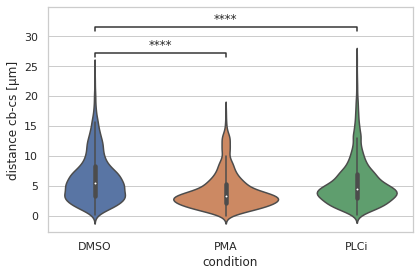

In [21]:
data = df_full
y='distance cb-cs [µm]'
x='condition'
order = ['DMSO', 'PMA', 'PLCi']
box_pairs = [('DMSO', 'PMA'),
             ('DMSO', 'PLCi'),]
ax = plt.subplot(111)
sns.violinplot(
    data=data,
    y=y,
    x=x, 
    order = order,
)
statannot.add_stat_annotation(
    data=data,
    x=x,
    y=y,
    box_pairs=box_pairs,
    ax=ax,
    order=order,
    test='Kruskal',
    loc='inside', verbose=2,
    comparisons_correction='bonferroni'
)
plt.tight_layout()
plt.savefig('plots/fig8B.png')

### Fig. 8 C: Centrosome dynamics

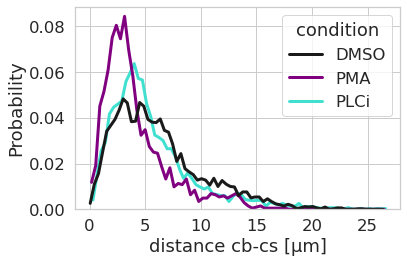

In [22]:
sns.set(font_scale=1.5, style='whitegrid')
sns.histplot(data=df_full,
             x='distance cb-cs [µm]',
             hue='condition', 
             hue_order = ['DMSO', 'PMA', 'PLCi'],
             stat='probability', common_norm=False,
             element='poly',
             multiple='dodge',
             palette=['k', 'purple', 'turquoise'],
            fill=False, 
            linewidth=3)
plt.tight_layout()
plt.savefig('plots/fig8C.png')

### Fig. 8 E: Successful engulfments

In [23]:
df_plot = c_df.loc[(c_df['condition'] == 'DMSOctrl') |
                   (c_df['condition'] == 'PMA') |
                   (c_df['condition'] == 'PLCi')].copy()
df_plot.loc[df_plot['condition'] == 'DMSOctrl', 'condition'] = 'DMSO'

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DMSO v.s. PMA: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.855e-07 stat=2.573e+01
DMSO v.s. PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.014e-02 stat=5.406e+00


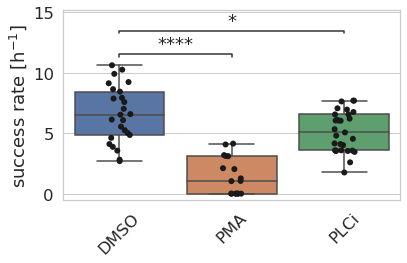

In [24]:
x = 'condition'
y = 'success rate'
order = ['DMSO', 'PMA', 'PLCi']
box_pairs = [('DMSO', 'PMA'),
             ('DMSO', 'PLCi'),]
ax = plt.subplot(111)
sns.boxplot(data=df_plot,
            x=x,
            y=y,
           ax=ax,
           order=order)
sns.stripplot(
    data=df_plot,
    x=x,
    y=y,
    size=6, color='k', linewidth=0, dodge=True,
    order=order,
)
statannot.add_stat_annotation(
    data=df_plot,
    x=x,
    y=y,
    box_pairs=box_pairs,
    ax=ax,
    order=order,
    test='Kruskal',
    loc='inside', verbose=1,
    comparisons_correction='bonferroni'
)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('{} [h$^{{-1}}$]'.format(y))
plt.tight_layout()
plt.savefig('plots/fig8E.png')

### Fig. 8 F: Total phagocytosis attemts

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DMSO v.s. PMA: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.287e-01
DMSO v.s. PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.022e-01 stat=2.688e+00


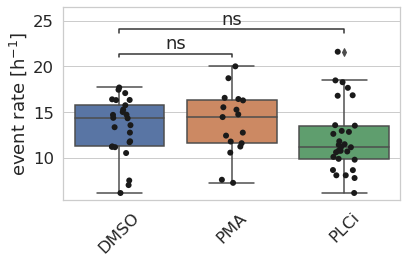

In [25]:
x = 'condition'
y = 'event rate'
order = ['DMSO', 'PMA', 'PLCi']
box_pairs = [('DMSO', 'PMA'),
             ('DMSO', 'PLCi'),]
ax = plt.subplot(111)
sns.boxplot(data=df_plot,
            x=x,
            y=y,
           ax=ax,
           order=order)
sns.stripplot(
    data=df_plot,
    x=x,
    y=y,
    size=6, color='k', linewidth=0, dodge=True,
    order=order,
)
statannot.add_stat_annotation(
    data=df_plot,
    x=x,
    y=y,
    box_pairs=box_pairs,
    ax=ax,
    order=order,
    test='Kruskal',
    loc='inside', verbose=1,
    comparisons_correction='bonferroni'
)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('{} [h$^{{-1}}$]'.format(y))
plt.tight_layout()
plt.savefig('plots/fig8F.png')

### Fig. 8 G: Centrosomal tracks for different drug treatments

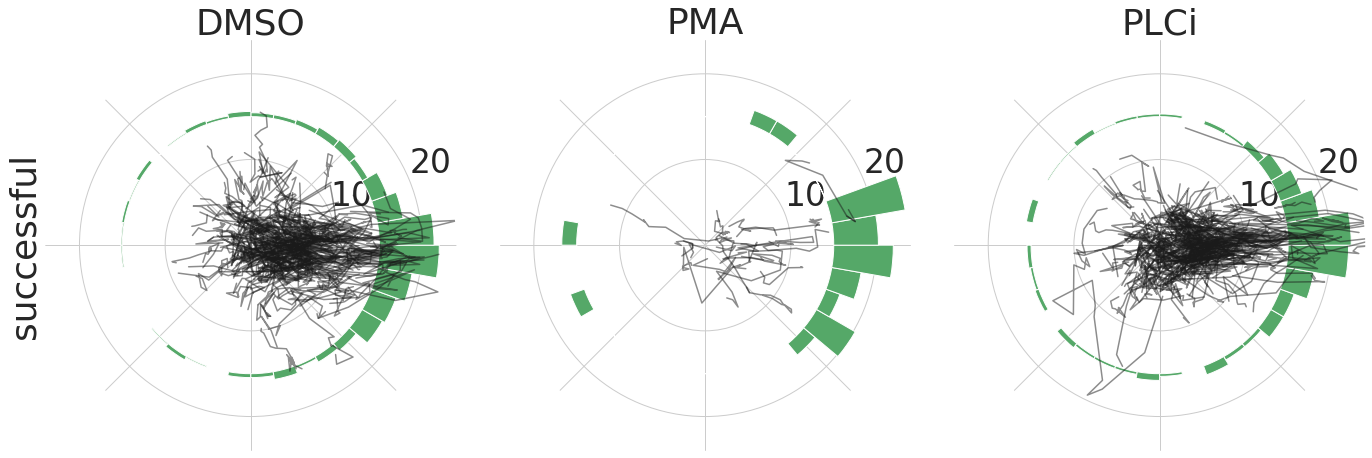

In [26]:
conditions = ['DMSO', 'PMA', 'PLCi']
modes = ['successful']

df_e = events.copy()
df_e.loc[df_e['condition'] == 'DMSOctrl', 'condition'] = 'DMSO'
df_e.loc[df_e['phagocytic mode'] == 'failure', 'phagocytic mode'] = 'aborted'
df_e.loc[df_e['phagocytic mode'] == 'non-branch', 'phagocytic mode'] = 'successful'
df_e.loc[df_e['phagocytic mode'] == 'branch', 'phagocytic mode'] = 'successful'

fig = plt.figure(figsize=(20,13))
sns.set(font_scale=3, style='whitegrid')
i = 0

for mode in modes:
    for cond in conditions:
        if mode == 'successful':
            color = 'g'
        elif mode == 'aborted':
            color = 'r'
        i+=1
        ax = plt.subplot(1,3, i, projection='polar')
        if i < 4:
            ax.set_title(cond)
            
        if (i-1) % 3 == 0:
            ax.set_ylabel(mode)
        ax.set_xticklabels([])
        ax.set_yticks([10,20])
        ax.set_ylim(0,24)
        ax.spines['polar'].set_visible(False)
        sevents = df_e.loc[(df_e['condition'] == cond) & (df_e['phagocytic mode']==mode)]
        rs = []
        phis = []
        for evid in sevents['event id'].unique():
            sdf = sevents.loc[sevents['event id'] == evid].copy()
            if len(sdf.index) == 0:
                continue
            sdf.reset_index(inplace=True, drop=True)
            try:
                c_idx = sdf.loc[sdf['time event [min]']==1].index[0]
            except IndexError:
                c_idx = sdf.loc[sdf['time event [min]']==0].index[0]
            x = sdf['centrosome x [µm]'].values - sdf['cell body x [µm]'].values
            y = sdf['centrosome y [µm]'].values - sdf['cell body y [µm]'].values
            r, phi = cart2pol(x,y)
            xp = sdf['phagosome x [µm]'].dropna().values[0] - sdf['cell body x [µm]'].values
            yp = sdf['phagosome y [µm]'].dropna().values[0] - sdf['cell body y [µm]'].values
            rp, phip = cart2pol(xp,yp)
            phi -= phip
            rs.append(r[c_idx])
            phis.append(phi[c_idx])
            ax.plot(phi, r, 'k', alpha=.5)
        circular_hist(ax, np.array(phis), density=False, gaps=False,bins=36, color=color)
plt.tight_layout()
plt.savefig('plots/fig8G.png')

### Fig. 8 H: Centrosome motility during phagocytosis

In [27]:
df_es = event_stats.copy()
df_es.loc[df_es['condition'] == 'DMSOctrl', 'condition'] = 'DMSO'
df_es = df_es.loc[(df_es['condition'] != 'PKCi')]
df_es.loc[df_es['phagocytic mode'] == 'failure', 'mode'] = 'aborted'
df_es.loc[df_es['phagocytic mode'] == 'non-branch', 'mode'] = 'successful'
df_es.loc[df_es['phagocytic mode'] == 'branch', 'mode'] = 'successful'

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

aborted_PMA v.s. aborted_PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.984e-03 stat=1.289e+01
successful_DMSO v.s. successful_PMA: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.766e-01
successful_PMA v.s. successful_PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.239e-01
aborted_DMSO v.s. aborted_PMA: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.048e-08 stat=3.416e+01
aborted_DMSO v.s. aborted_PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.514e-03 stat=1.041e+01
successful_DMSO v.s. successful_PLCi: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.031e-01 stat=2.454e+00


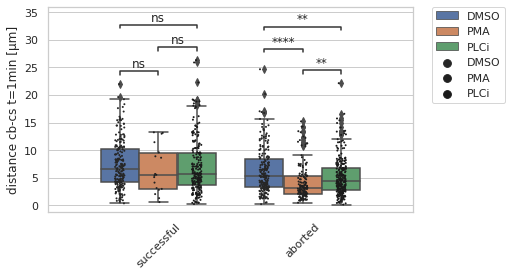

In [28]:
sns.set(style='whitegrid', font_scale=1)

data = df_es
x = 'mode'
y = 'distance cb-cs t=1min [µm]'
hue = 'condition'

hue_order = ['DMSO', 'PMA', 'PLCi']
order = ['successful', 'aborted']

box_pairs = [(('successful', 'DMSO'), ('successful', 'PMA')),
             (('successful', 'DMSO'), ('successful', 'PLCi')),
             (('successful', 'PMA'), ('successful', 'PLCi')),
             (('aborted', 'DMSO'), ('aborted', 'PMA')),
             (('aborted', 'DMSO'), ('aborted', 'PLCi')),
             (('aborted', 'PMA'), ('aborted', 'PLCi')),
            ]

ax = plt.subplot(111)
sns.boxplot(data=data,
            x=x,
            y=y,
            ax=ax,
            hue=hue,
            hue_order=hue_order,
           order=order,
           )
sns.stripplot(
    data=data,
    x=x,
    y=y,
    hue=hue,
    hue_order=hue_order,
    size=2, color='k', linewidth=0, dodge=True,
    order=order,
)
statannot.add_stat_annotation(
    data=data,
    x=x,
    y=y,
    box_pairs=box_pairs,
    ax=ax,
    order=order,
    hue=hue,
    hue_order=hue_order,
    test='Kruskal',
    loc='inside', verbose=1,
    comparisons_correction='bonferroni'
)

plt.xticks(rotation=45)
plt.xlabel('')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plots/fig8H.png')